# PyDMD

## Copy from sara

In this tutorial, we will create from scratch a new version of the original DMD; 

Such an extension will be totally useless from a scientific perspective, the only purpose is showing the suggested steps to implement new variants inside **PyDMD**.

The necessary bricks for building the new DMD version are:

- [`DMDBase`](https://mathlab.github.io/PyDMD/dmdbase.html), the actual backbone of all the different implemented versions;
- `DMDTimeDict`, the class that manages the time window;
- `DMDOperator`, the class that manages the so-called DMD operator;

We start the new module by importing all these classes and the usual math environment (`matplotlib`+`numpy`).

In [1]:
#!pip install git+https://github.com/PyDMD/PyDMD.git@cbd7c923b2cc58ba1ab116b16295101adc256bbb

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from pydmd import DMDBase, DMD
from pydmd.utils import compute_tlsq
from pydmd.snapshots import Snapshots

import matplotlib.colors as colors

We are now able to create a new class inheriting from `DMDBase`: in this way we just need to implement the new `fit()` method. We can also overload one or more attributes/methods, depending on the algorithm which we are going to follow.

In this case, we also overload the constructor (i.e. the `__init__` method) to present a non-trivial case. 

### Our simple algorithm
The new functionality we are going to implement is basically a simple DMD which maps the input snapshots using a custom function, provided by the user before of the construction of the operator.

Since the (quite) high number of parameters in the constructor, we suggest to pass explicitly all of them instead of using `args` and `kwargs`. It's redundant, but also much more readable! We can call the `DMDBase` constructor thanks to `super` keyword (more info on `super` [here](https://docs.python.org/3.9/library/functions.html?highlight=super#super)).

In [3]:
class MyFancyNameDMD(DMDBase):
    """
    The MyFancyNameDMD class.
    A dummy DMD variant which, useless outside this tutorial.
    Make sure to write an exhaustive docstring if you want to
    distribute your code, or use it again in some years.
    """

    def __init__(self, func, **kwargs):
        super().__init__(**kwargs)
        self.__func = func

We just specify that the last line of constructor saves the passed function in the object, giving us the possibility to recall it later.

We are now ready to implement the `fit` method. Define the custom mapping as $f: \mathbb R^n \to \mathbb R^n$ acting on the snapshots $\{\mathbf x_i \in \mathbb R^n\}_{i=1}^m$. Then we just need to pre-process the snapshots in `fit()` and build the DMD operator.

By recalling the already implemented methods, we just need few lines of code to complete the new version. Of course, in case of doubts, the [documentation](https://mathlab.github.io/PyDMD/index.html) is the best starting point to better understand classes and methods.

We merge the two cells above in the next one in order to have the entire class implemented.

In [4]:
class MyFancyNameDMD(DMDBase):
    """
    The MyFancyNameDMD class.
    A dummy DMD variant which, useless outside this tutorial.
    Make sure to write an exhaustive docstring if you want to
    distribute your code, or use it again in some years.
    """

    def __init__(self, func, **kwargs):
        super().__init__(**kwargs)
        self.__func = func

    def fit(self, X):
        """
        Compute the DMD to the input data.

        :param X: the input snapshots.
        :type X: numpy.ndarray or iterable
        """

        # adjust the shape of the snapshots
        input_snapshots = Snapshots(X).snapshots
        
        #####################################################
        # apply the mapping
        #####################################################
        mapped_snapshots = np.apply_along_axis(self.__func, 0, input_snapshots)
        
        # store the snapshots
        self._snapshots_holder = Snapshots(mapped_snapshots)
        
        # build the matrices X and Y
        n_samples = self.snapshots.shape[-1]
        X = self.snapshots[:, :-1]
        Y = self.snapshots[:, 1:]
        X, Y = compute_tlsq(X, Y, self._tlsq_rank)

        # compute the DMD operator
        self._svd_modes, _, _ = self.operator.compute_operator(X, Y)

        # Default timesteps
        self._set_initial_time_dictionary(
            {"t0": 0, "tend": n_samples - 1, "dt": 1}
        )

        # compute DMD amplitudes
        self._b = self._compute_amplitudes()

        return self

And, we're done!

Our new class is implemented, inheriting all the methods to the base class. We have nothing to do but try it on a simple example. First of all, we instantiate a new object, passing as function a simple normalizer.

We recycle the dataset from [tutorial 1](https://mathlab.github.io/PyDMD/tutorial1dmd.html):

In [5]:
def f1(x, t):
    return 1.0 / np.cosh(x + 3) * np.exp(2.3j * t)


def f2(x, t):
    return (2.0 / np.cosh(x) * np.tanh(x) * np.exp(2.8j * t))


x = np.linspace(-5, 5, 65)
t = np.linspace(0, 4 * np.pi, 129)

xgrid, tgrid = np.meshgrid(x, t)

X1 = f1(xgrid, tgrid)
X2 = f2(xgrid, tgrid)
X = X1 + X2 + 1e6

In [6]:
def subtract(snapshot):
    return snapshot - 1e6


my_dmd = MyFancyNameDMD(func=subtract, svd_rank=2)
dmd = DMD(svd_rank=2)

[dmd_.fit(X.T) for dmd_ in [my_dmd, dmd]]

/Users/ndemo/miniconda3/lib/python3.11/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 7.954591736361719e+17. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/Users/ndemo/miniconda3/lib/python3.11/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 448199816866.91974. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


[<__main__.MyFancyNameDMD at 0x12f955610>, <pydmd.dmd.DMD at 0x13a4f8610>]

The `fit` method we have implemented is now called to perform our algorithm to the input data.

To check that everything works as expected we compare the results obtained with the new version with respect to the original standard approach. We import the `DMD` class and fit over the same data.

We have performed both the algorithms, we can now look at the reconstructed system using the `reconstructed_data` attribute. We note here that, as the other methods and attributes, `reconstructed_data` is inherited from `DMDBase`, giving us the possibility to call it without having implemented explicitly.

In [7]:
def compare_dmds(dmds, ground_truth):

    fig = plt.figure(layout=None, figsize=(18, 6*len(dmds)))
    gs = fig.add_gridspec(nrows=len(dmds)+2, ncols=2, left=0.05, right=0.95,
                      hspace=0.4, wspace=0.05)
    ax0 = fig.add_subplot(gs[:2, :])
    cb = ax0.pcolormesh(ground_truth.real.T)
    plt.colorbar(cb)

    for i, dmd_ in enumerate(dmds):
        ax1 = fig.add_subplot(gs[i+2, 0])
        ax2 = fig.add_subplot(gs[i+2, 1])
        cb = ax1.pcolormesh(dmd_.reconstructed_data.real)
        plt.title(f"{dmd_.__class__.__name__} Reconstruction")
        plt.xlabel("t")
        plt.ylabel("x")
        plt.colorbar(cb)
        
        Z = np.abs(dmd_.reconstructed_data.real - ground_truth.T)
        pcm = ax2.pcolormesh(
            Z,
            norm=colors.LogNorm(vmin=max(1.0e-16, Z.min()), vmax=max(1.0e-15, Z.max())),
        )
        ax2.set_title(f"{dmd_.__class__.__name__} Error")
        ax1.set_title(f"{dmd_.__class__.__name__} Reconstruction")

        plt.xlabel("t")
        plt.ylabel("x")
        plt.colorbar(pcm, extend="max")
    
    #plt.tight_layout()
    plt.show()

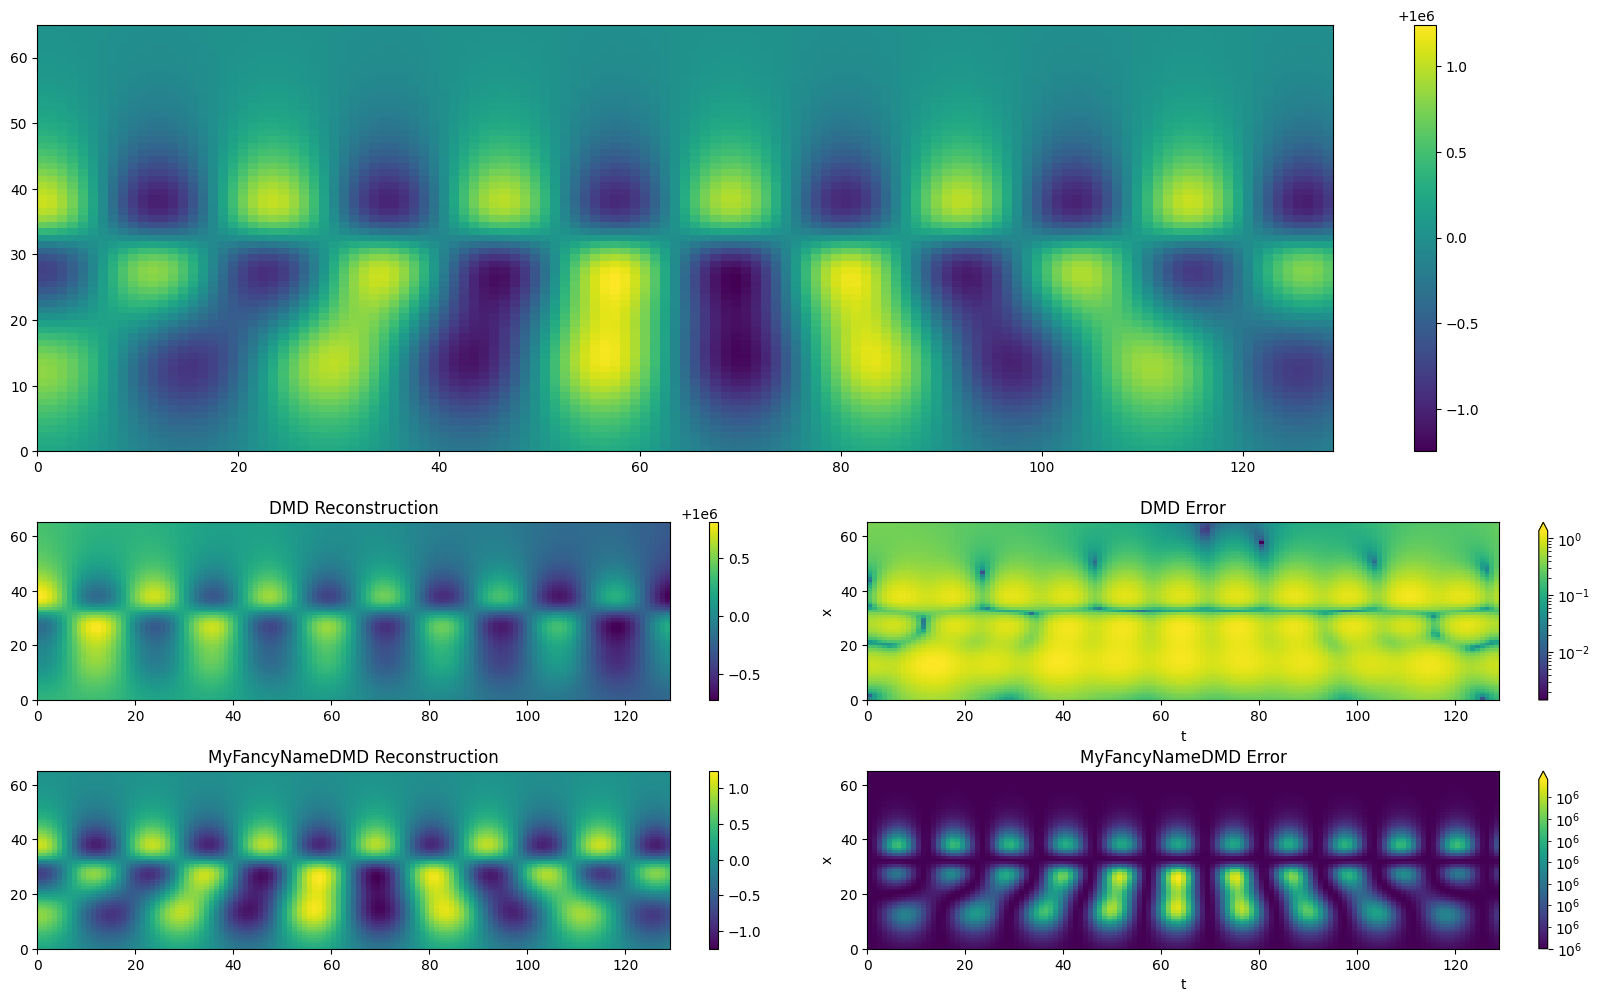

In [8]:
compare_dmds([dmd, my_dmd], X)

Reconstruction looks fine! We are able to note that, since the normalization of the snapshots, the two approaches returns similar results, just a bit rescaled, that is what we expected by preprocessing in this way the input data.

But what about if we want to rescale back the reconstruction (or the modes) in the new version?
Simple, we have just to overload the `reconstructed_data` or `modes` attributes. 

This is the basic guide to implement a new version of DMD. For more complex changes to the algorithm, we recommend to carefully read the documentation of the package, and maybe reporting in the [Github issues page](https://github.com/mathLab/PyDMD/issues) the extension you are going to implement.

## Exercise 3a

Plot the (1D) modes for the new class, and compare them to the standard ones.

/Users/ndemo/miniconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


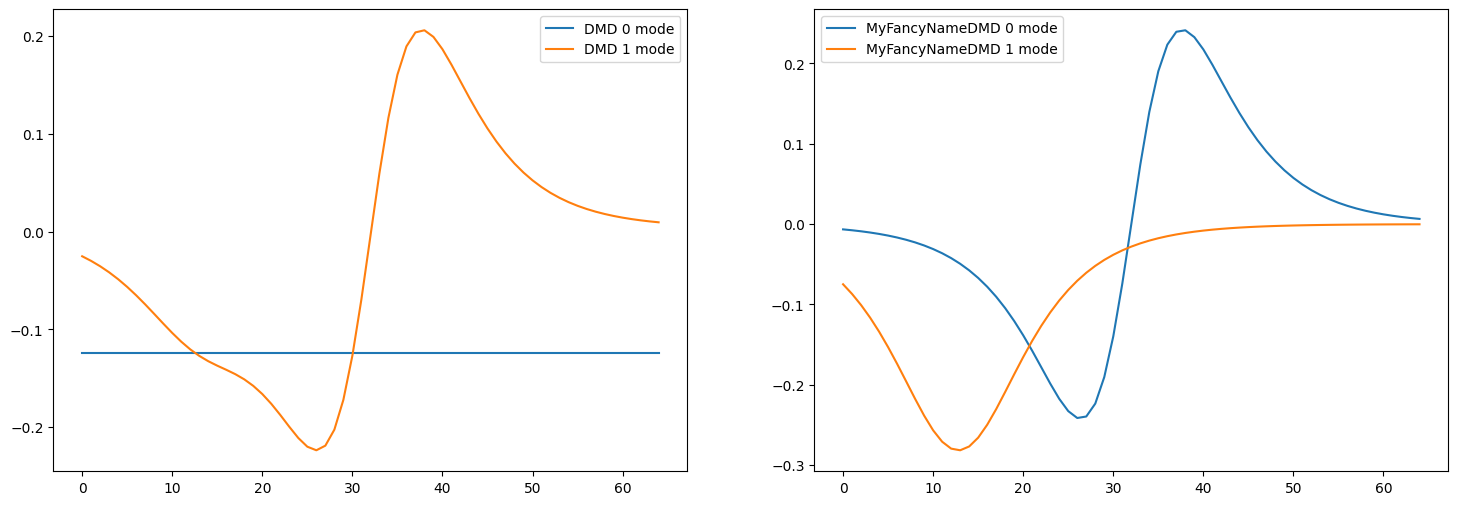

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
for dmd_, ax_ in zip([dmd, my_dmd], axs):
    for i, mode in enumerate(dmd_.modes.T):
        ax_.plot(mode, label=f'{dmd_.__class__.__name__} {i} mode')
    ax_.legend()

## Exercise 3b

Plot the dynamics for the new class, and compare them to the standard ones.

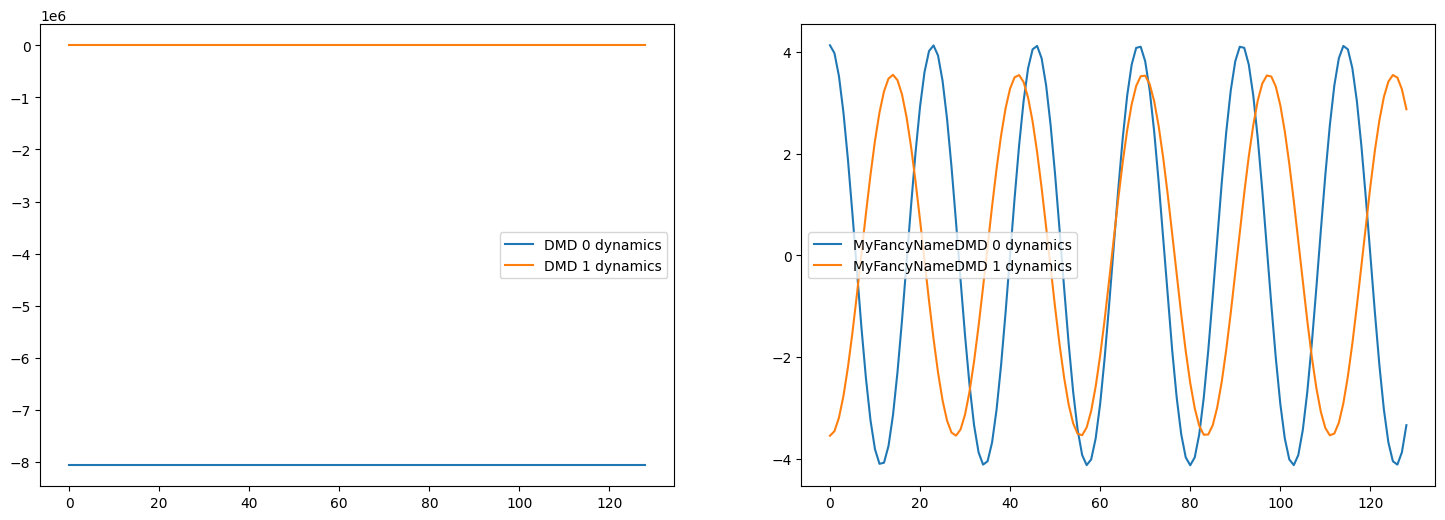

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
for dmd_, ax_ in zip([dmd, my_dmd], axs):
    for i, mode in enumerate(dmd_.dynamics):
        ax_.plot(mode, label=f'{dmd_.__class__.__name__} {i} dynamics')
    ax_.legend()

## Exercise 3c

Plot the eigenvalues for the new class, and compare them to the standard ones.

In [11]:
from pydmd.plotter import plot_eigs
from ipywidgets import interact, interactive, fixed, interact_manual

@interact(dmd_=[dmd, my_dmd])
def interactive_eigs(dmd_):
    plot_eigs(dmd_, figsize=(6, 6), title=f'{dmd_.__class__.__name__}', show_axes=True, narrow_view=True)

interactive(children=(Dropdown(description='dmd_', options=(<pydmd.dmd.DMD object at 0x13a4f8610>, <__main__.M…

# Part 2: Another, more complete, class

Exercise

In [12]:
class MyFancyName2DMD(MyFancyNameDMD):

    def __init__(self, inverse_transformation_func, transformation_func, *args, **kwargs):
        super().__init__(transformation_func, *args, **kwargs)
        self.__inverse_transformation_func = inverse_transformation_func

    # COMPLETE HERE

Solution

In [13]:
class MyFancyName2DMD(MyFancyNameDMD):

    def __init__(self, inverse_transformation_func, transformation_func, *args, **kwargs):
        super().__init__(transformation_func, *args, **kwargs)
        self.__inverse_transformation_func = inverse_transformation_func

    @property
    def reconstructed_data(self):
        return self.__inverse_transformation_func(MyFancyNameDMD.reconstructed_data.fget(self))

In [14]:
def sum(snapshots):
    return snapshots + 1e6
    
my2nd_dmd = MyFancyName2DMD(inverse_transformation_func=sum, transformation_func=subtract, svd_rank=2)
my2nd_dmd.fit(X.T)

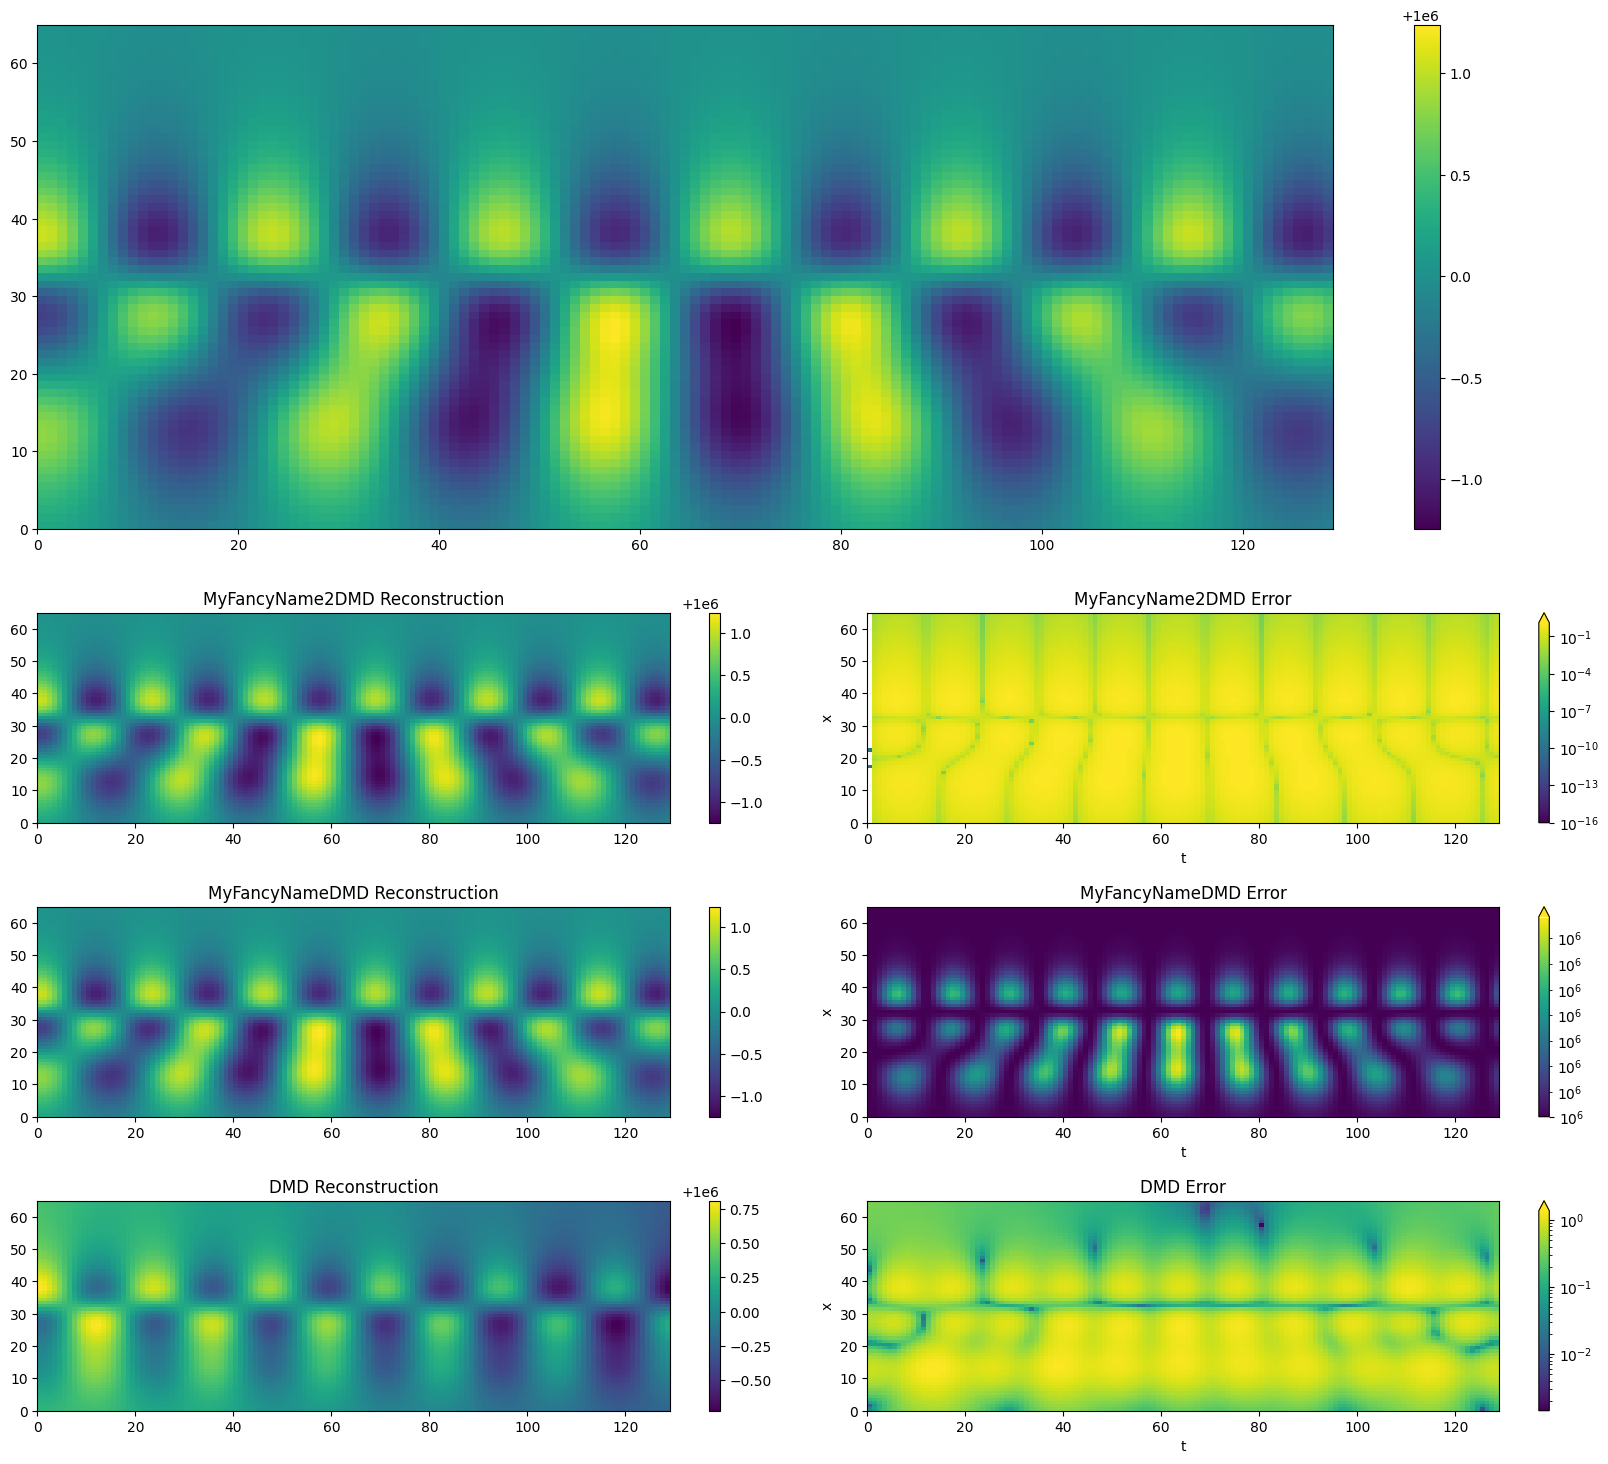

In [15]:
compare_dmds([my2nd_dmd, my_dmd, dmd], X)

## Esericizio
What happen when you swap the functions?

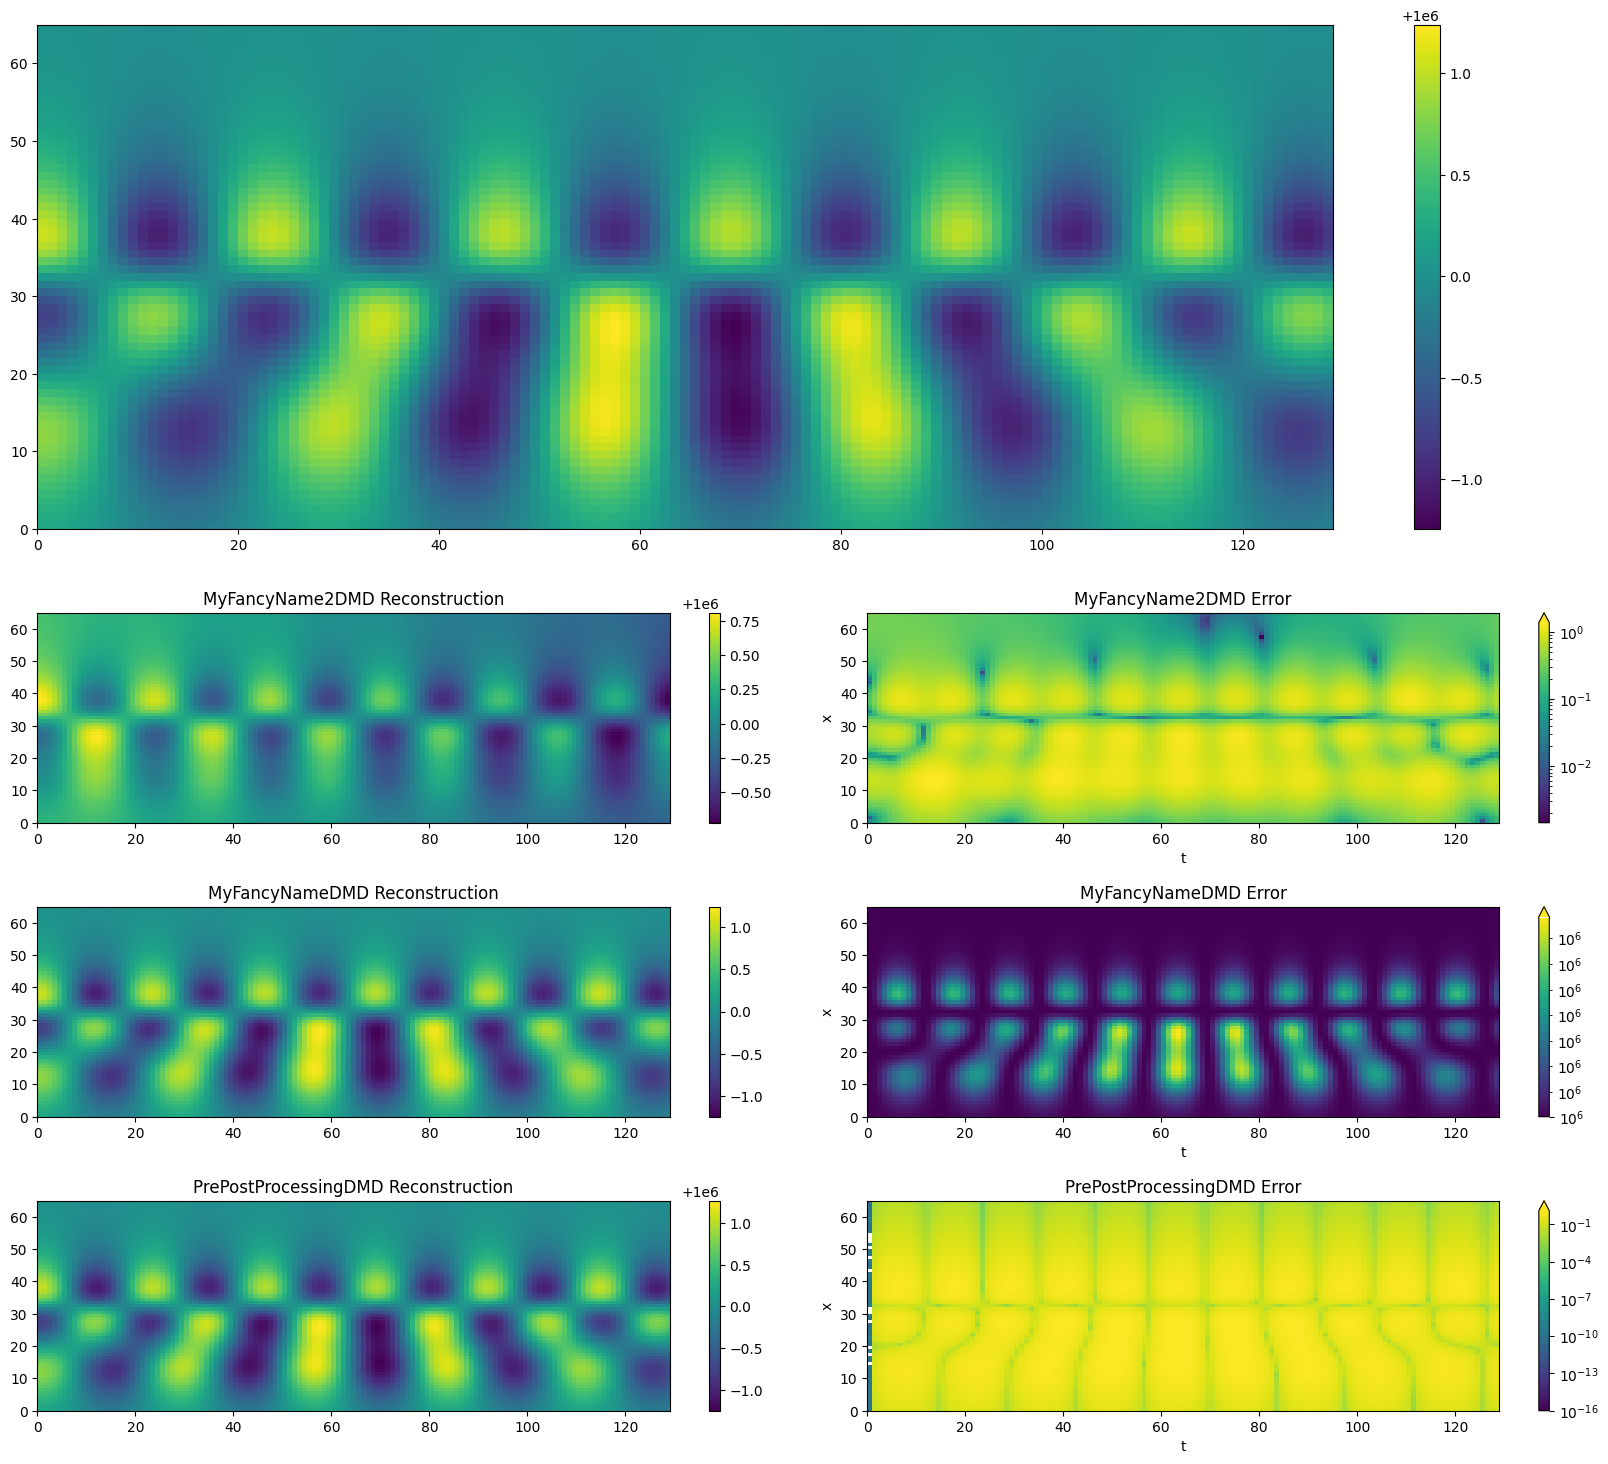

In [20]:
my2nd_dmd = MyFancyName2DMD(inverse_transformation_func=subtract, transformation_func=sum, svd_rank=2)
my2nd_dmd.fit(X.T)
compare_dmds([my2nd_dmd, my_dmd, dmd], X)

/Users/ndemo/miniconda3/lib/python3.11/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 448766176342.27985. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/Users/ndemo/miniconda3/lib/python3.11/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 8.239986846222304e+17. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/Users/ndemo/miniconda3/lib/python3.11/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 8.070774173084801e+17. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


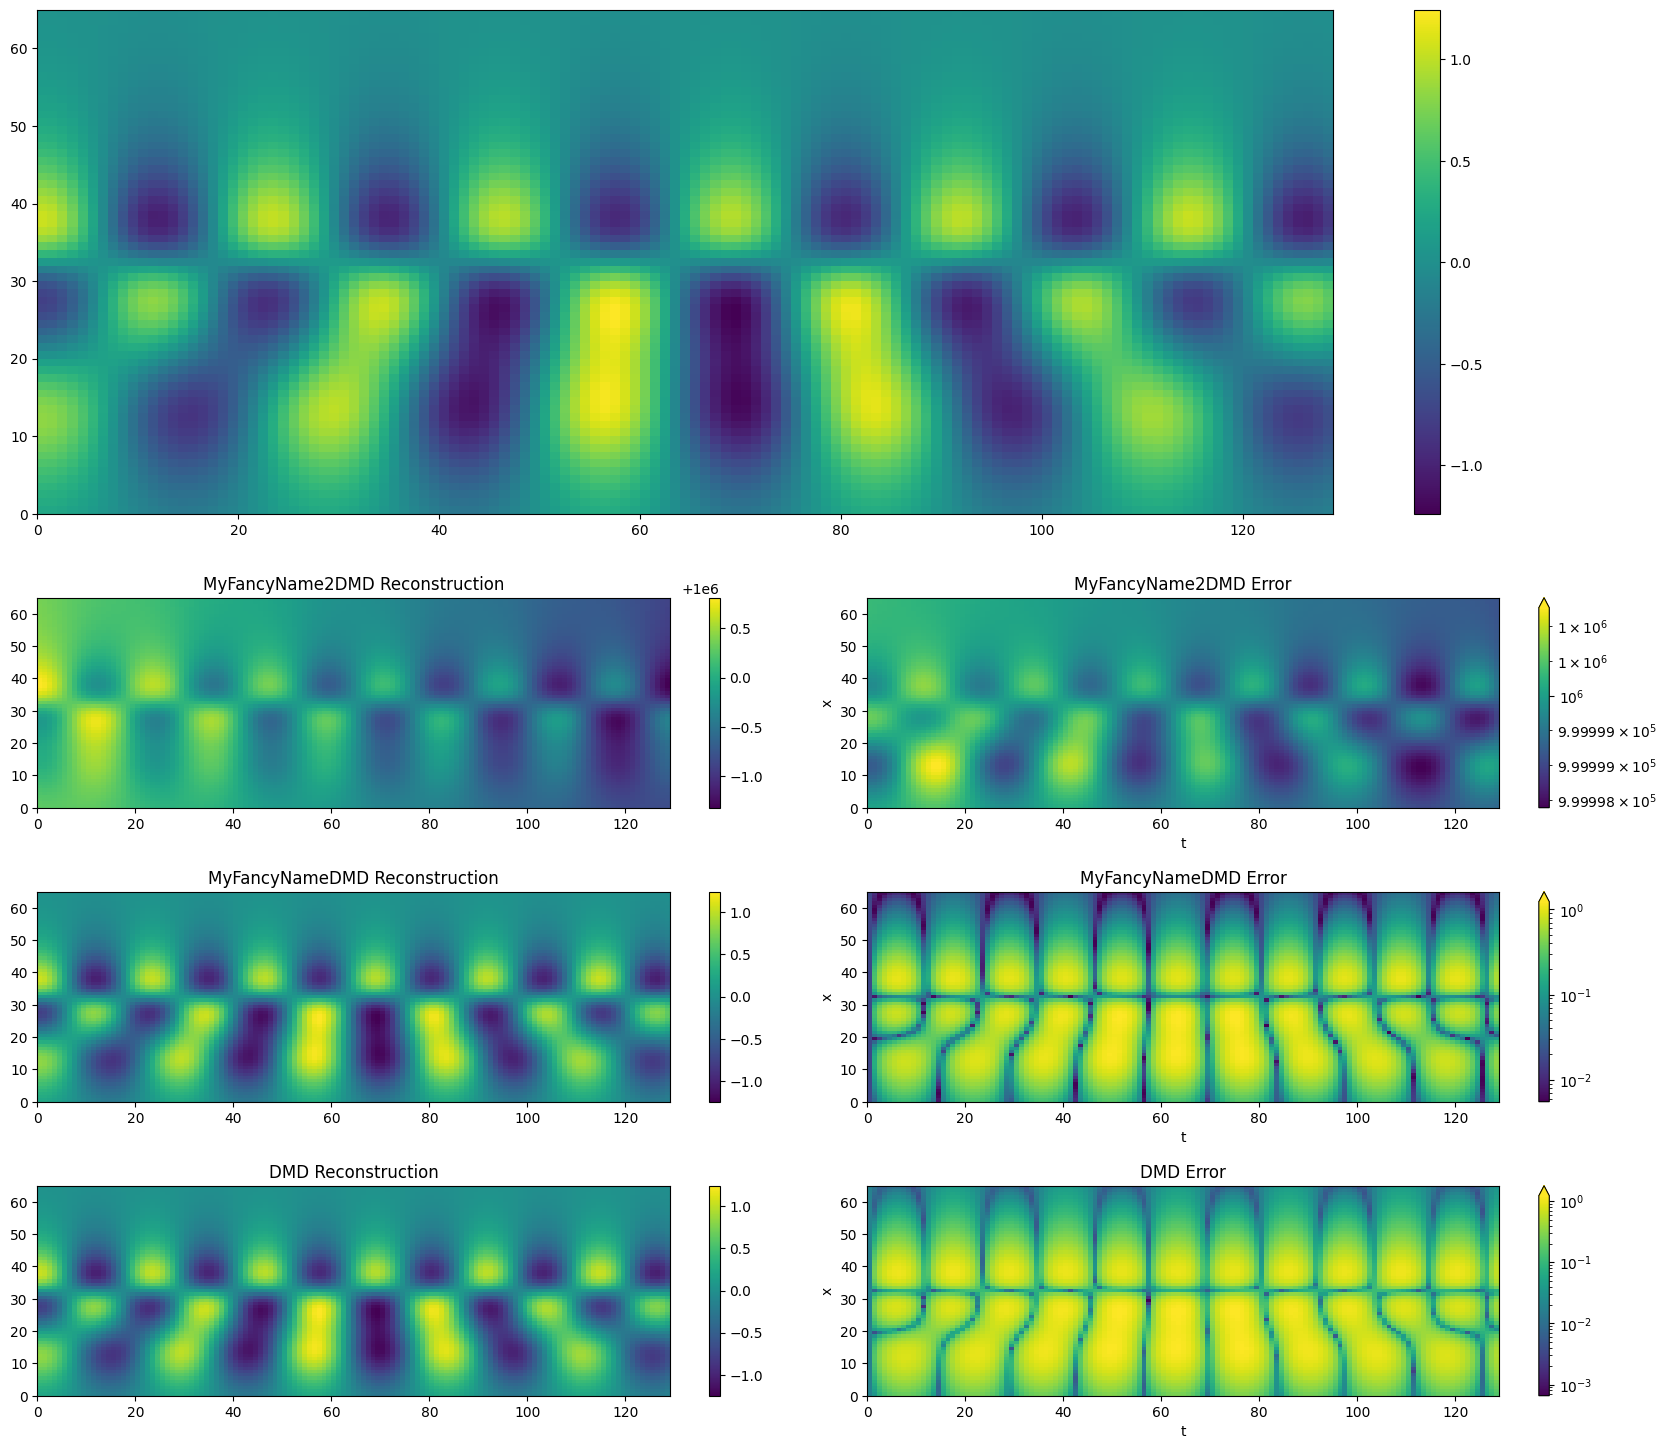

In [17]:
Xscaled = X - X.mean()

[dmd_.fit(Xscaled.T) for dmd_ in [my2nd_dmd, my_dmd, dmd]]
compare_dmds([my2nd_dmd, my_dmd, dmd], Xscaled)

## Exercise 3d
Create a new version for making "zero_mean" preprocessing on the input data.

In [18]:
from pydmd.preprocessing import zero_mean_preprocessing

dmd = zero_mean_preprocessing(dmd, axis=1)
[dmd_.fit(X.T) for dmd_ in [my2nd_dmd, my_dmd, dmd]]

/Users/ndemo/miniconda3/lib/python3.11/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 447521382243.32336. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


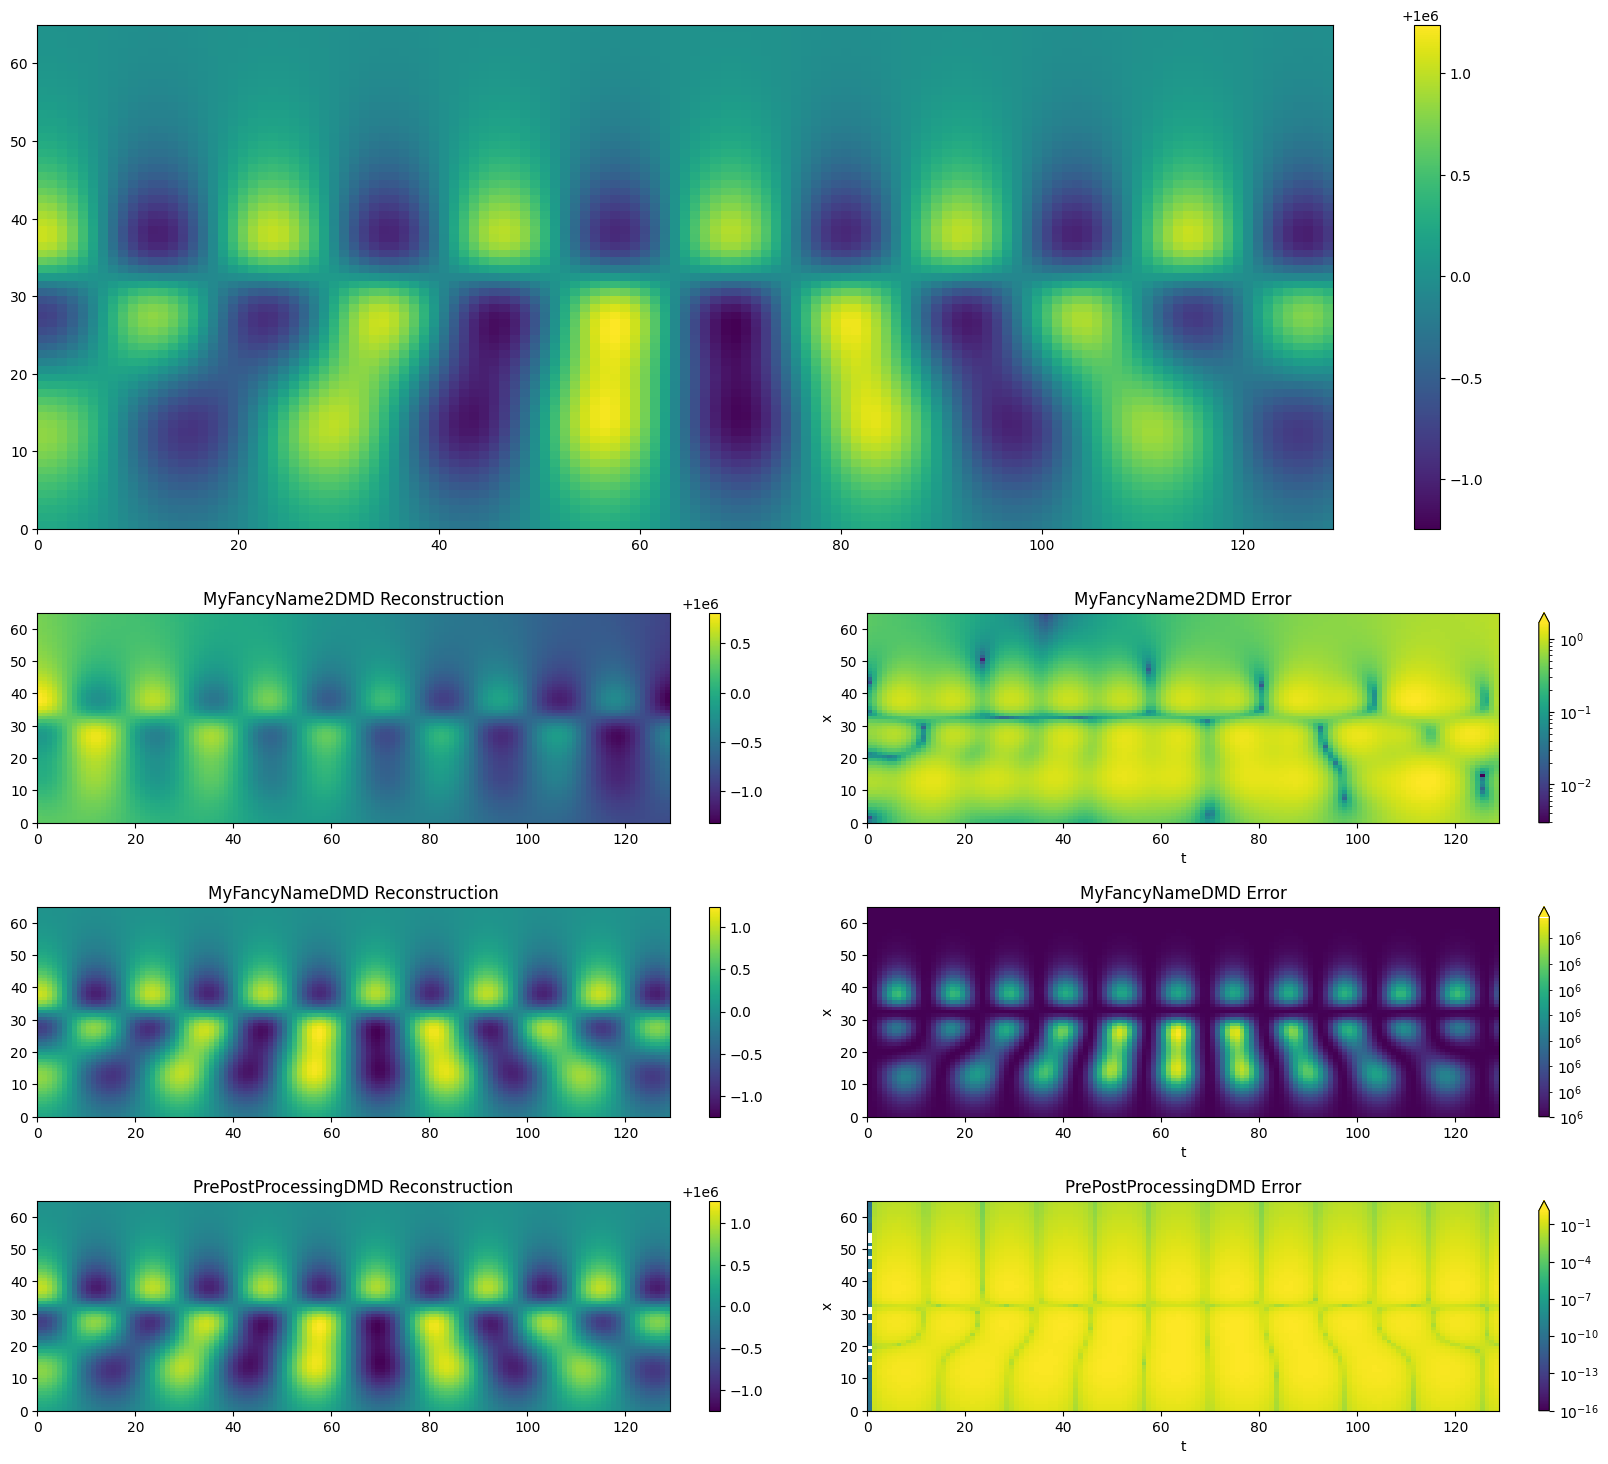

In [19]:
compare_dmds([my2nd_dmd, my_dmd, dmd], X)